Initial shape: (10000, 14)
   UDI Product_ID Type  Air_temperature_K  Process_temperature_K  \
0    1     M14860    M              298.1                  308.6   
1    2     L47181    L              298.2                  308.7   
2    3     L47182    L              298.1                  308.5   
3    4     L47183    L              298.2                  308.6   
4    5     L47184    L              298.2                  308.7   

   Rotational_speed_rpm  Torque_Nm  Tool_wear_min  Machine_failure  TWF  HDF  \
0                  1551       42.8              0                0    0    0   
1                  1408       46.3              3                0    0    0   
2                  1498       49.4              5                0    0    0   
3                  1433       39.5              7                0    0    0   
4                  1408       40.0              9                0    0    0   

   PWF  OSF  RNF  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0 

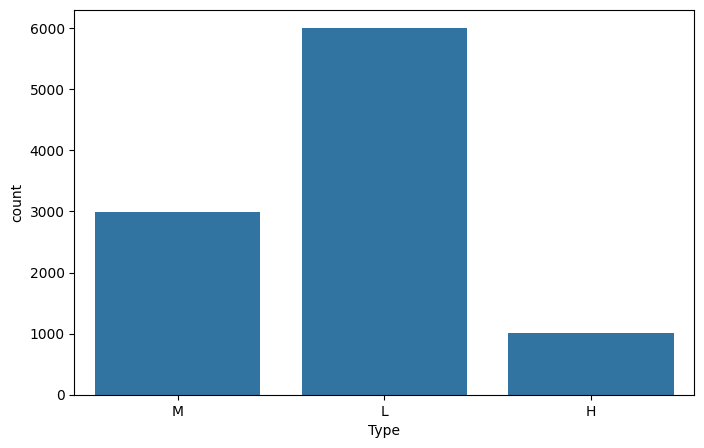

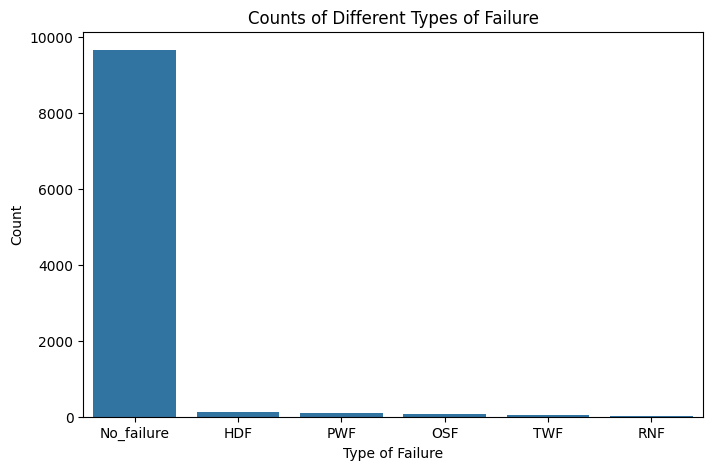

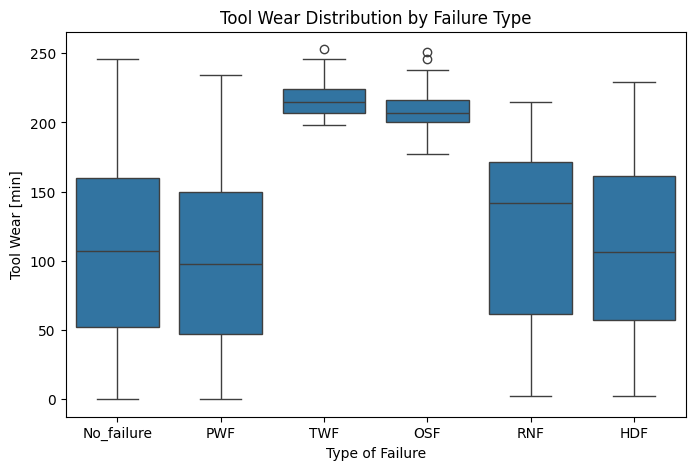

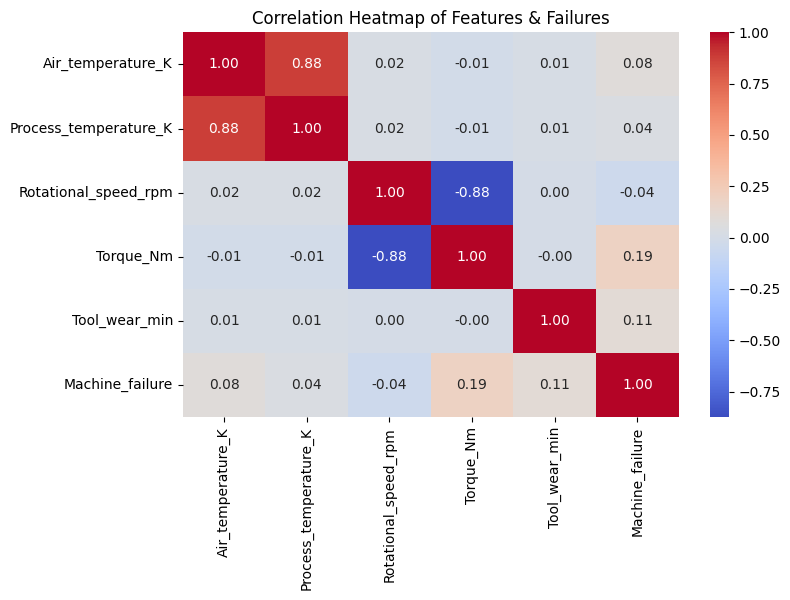

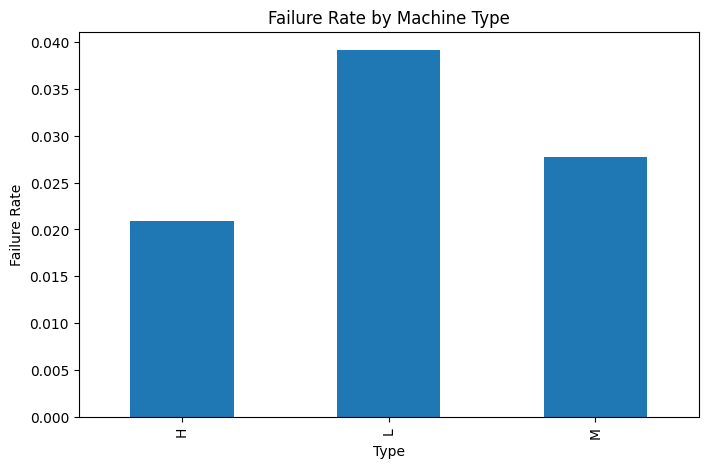

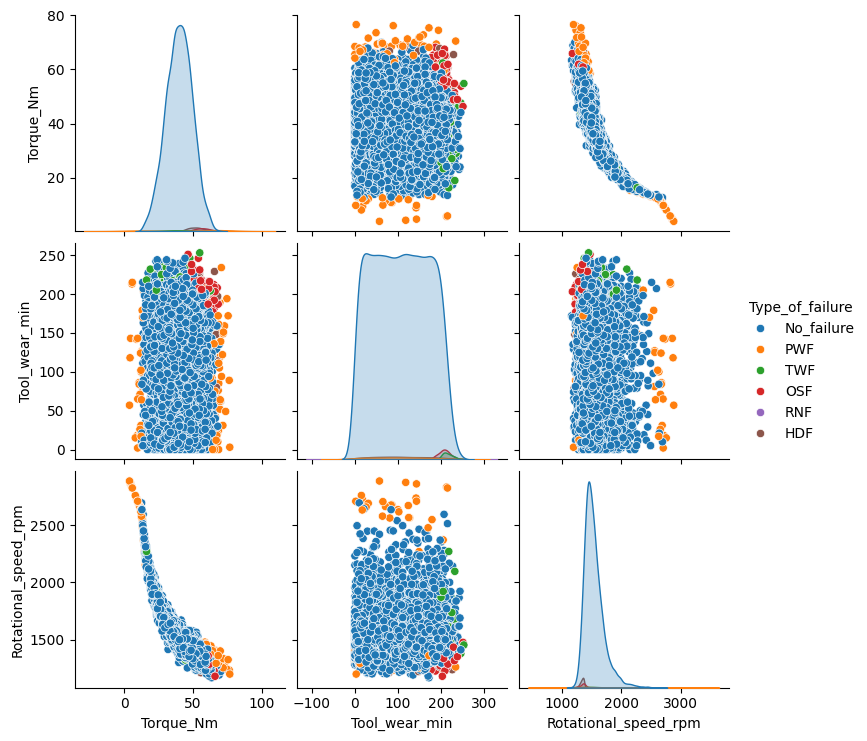

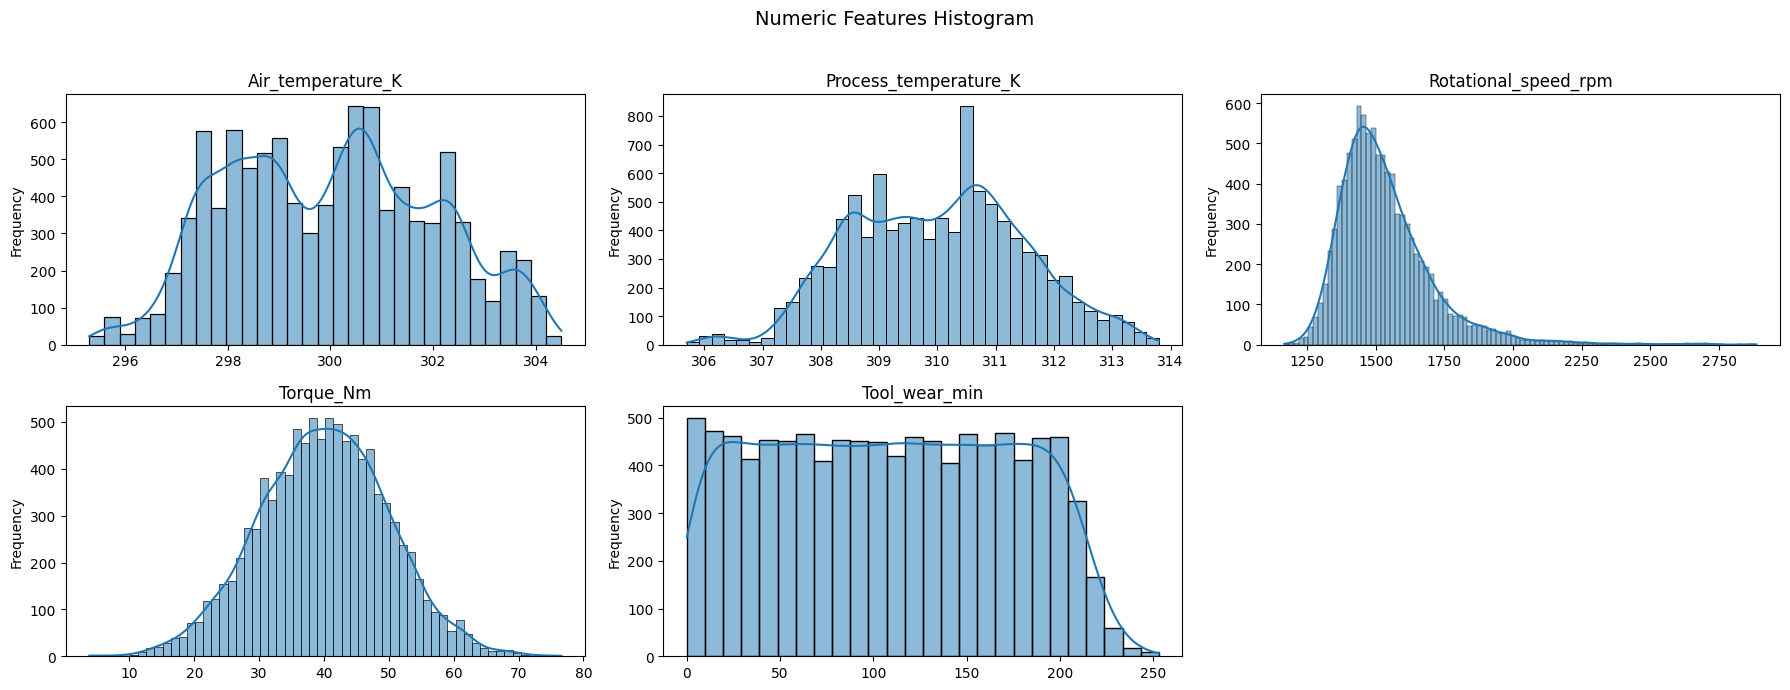

Type_of_failure
No_failure    96.52
HDF            1.15
PWF            0.91
OSF            0.78
TWF            0.46
RNF            0.18
Name: count, dtype: float64
                          T-stat       P-value     Decision
Air_temperature_K       7.981703  1.950809e-14  Reject Null
Process_temperature_K   3.898388  1.151324e-04  Reject Null
Rotational_speed_rpm   -2.086776  3.764748e-02  Reject Null
Torque_Nm              11.780813  3.635739e-27  Reject Null
Tool_wear_min           9.264290  1.906011e-18  Reject Null
  Type  Rotational_speed_rpm  Torque_Nm  Tool_wear_min  Machine_failure  \
0    M                  1551       42.8              0                0   
1    L                  1408       46.3              3                0   
2    L                  1498       49.4              5                0   
3    L                  1433       39.5              7                0   
4    L                  1408       40.0              9                0   

  Type_of_failure  Air_te

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import joblib
import warnings
warnings.filterwarnings("ignore")

# 1. Load raw data and clean column names once
df = pd.read_csv('raw.csv')
df.columns = (
    df.columns
    .str.strip()
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace('<', '', regex=False)
    .str.replace('>', '', regex=False)
    .str.replace(' ', '_', regex=False)
)
print(f"Initial shape: {df.shape}")
print(df.head())
print(df.info())

print(f"Duplicates count: {df.duplicated().sum()}")

# 2. Create 'Type_of_failure' target column
def type_of_failure(row):
    if row['TWF'] == 1:
        return 'TWF'
    elif row['HDF'] == 1:
        return 'HDF'
    elif row['PWF'] == 1:
        return 'PWF'
    elif row['OSF'] == 1:
        return 'OSF'
    elif row['RNF'] == 1:
        return 'RNF'
    else:
        return 'No_failure'

df['Type_of_failure'] = df.apply(type_of_failure, axis=1)

# Dropping unnecessary columns 
df.drop(['UDI', 'Product_ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

# 3. Your visualizations here (add your plotting code as needed)
# Visualizations 
# Visualizing the count of different types of machines (L:Light duty machines, M:Medium duty machines, H:Heavy duty machines)
plt.figure(figsize=(8,5))
sns.countplot(x = 'Type', data=df)
plt.show()

# Distribution of type_of_failure classes
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Type_of_failure', order=df['Type_of_failure'].value_counts().index)
plt.title('Counts of Different Types of Failure')
plt.xlabel('Type of Failure')
plt.ylabel('Count')
plt.show()

# Distribution of operational features by failure type
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Type_of_failure', y='Tool_wear_min')
plt.title('Tool Wear Distribution by Failure Type')
plt.xlabel('Type of Failure')
plt.ylabel('Tool Wear [min]')
plt.show()

# Heatmap of Correlation Matrix
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Features & Failures')
plt.show()

# Failure rate by 'Type' (categorical feature)
plt.figure(figsize=(8,5))
fail_rate = df.groupby('Type')['Machine_failure'].mean()
fail_rate.plot(kind='bar')
plt.title('Failure Rate by Machine Type')
plt.ylabel('Failure Rate')
plt.show()

# Pairplot of key numeric features colored by failure type
sns.pairplot(df, hue='Type_of_failure', vars=['Torque_Nm', 'Tool_wear_min', 'Rotational_speed_rpm'])
plt.show()

features = [
    'Air_temperature_K',
    'Process_temperature_K',
    'Rotational_speed_rpm',
    'Torque_Nm',
    'Tool_wear_min'
]

fig, axs = plt.subplots(2, 3, figsize=(18, 7))
axs = axs.flatten()

fig.suptitle('Numeric Features Histogram', fontsize=14)

for j, feature in enumerate(features):
    sns.histplot(ax=axs[j], data=df, x=feature, kde=True)
    axs[j].set_title(feature)
    axs[j].set_xlabel('')
    axs[j].set_ylabel('Frequency')

# Hide the last (6th) subplot since we have only 5 features
axs[-1].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Calculate category percentage
category_counts = df['Type_of_failure'].value_counts()
category_percentages = category_counts / len(df) * 100
print(category_percentages)

# Hypothesis testing
test_cols = ['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min']
hypothesis_results = []
for col in test_cols:
    failed_vals = df[df['Machine_failure']==1][col]
    non_failed_vals = df[df['Machine_failure']==0][col]
    t_stat, p_val = ttest_ind(failed_vals, non_failed_vals, equal_var=False)
    hypothesis_results.append([t_stat, p_val])
hypothesis_df = pd.DataFrame(hypothesis_results, columns=['T-stat', 'P-value'], index=test_cols)
hypothesis_df['Decision'] = hypothesis_df['P-value'].apply(lambda p: 'Reject Null' if p < 0.05 else 'Fail to Reject Null')
print(hypothesis_df)

# Convert kelvin to celsius
df['Air_temperature_C'] = df['Air_temperature_K'] - 273.15
df['Process_temperature_C'] = df['Process_temperature_K'] - 273.15
df.drop(['Air_temperature_K', 'Process_temperature_K'], axis=1, inplace=True)

print(df.head())

# 6. Modularized preprocessing pipeline focusing on encoding and scaling
class PreprocessingPipeline(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.type_encoder = OrdinalEncoder(categories=[['L', 'M', 'H']])
        self.failure_encoder = LabelEncoder()
        self.scaler = MinMaxScaler()
        self.scale_cols = ['Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min',
                           'Air_temperature_C', 'Process_temperature_C']

    def fit(self, X, y=None):
        self.type_encoder.fit(X[['Type']])
        self.failure_encoder.fit(X['Type_of_failure'])
        self.scale_cols = [col for col in self.scale_cols if col in X.columns]
        self.scaler.fit(X[self.scale_cols])
        return self

    def transform(self, X):
        X = X.copy()
        X['Type'] = self.type_encoder.transform(X[['Type']])
        if 'Type_of_failure' in X.columns:
            X['Type_of_failure'] = self.failure_encoder.transform(X['Type_of_failure'])
        X[self.scale_cols] = self.scaler.transform(X[self.scale_cols])
        return X

# 7. Fit preprocess and save processed data and pipeline
preprocessor = PreprocessingPipeline()
df_processed = preprocessor.fit_transform(df)
print("\nLabel Encoding Mapping (Type_of_failure):")
print(dict(zip(preprocessor.failure_encoder.classes_,
               preprocessor.failure_encoder.transform(preprocessor.failure_encoder.classes_))))
print(df_processed.head())

# Save processed CSV for later use
df_processed.to_csv('data_preprocessed.csv', index=False)
print("Processed data saved to 'data_preprocessed.csv'")

# Save the preprocessor pipeline
joblib.dump(preprocessor, 'preprocessing_pipeline.pkl')
print("Preprocessing pipeline saved as 'preprocessing_pipeline.pkl'")

In [2]:
# --------- Binary classification ---------
binary_df = pd.read_csv('data_preprocessed.csv')
print(binary_df.head())
print(binary_df.shape)
print(binary_df.info())

# Drop multiclass target for binary classification
binary_df = binary_df.drop(['Type_of_failure'], axis=1)

# Features and target
X1 = binary_df.drop(columns=['Machine_failure'])
y1 = binary_df['Machine_failure']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]
print(f"Numeric columns: {len(num_cols)}, Categorical columns (left as-is): {len(cat_cols)}")

# Target inspection
print(f"Unique values in y_train: {y_train.unique()}")
print(f"Unique values in y_test: {y_test.unique()}")
print(f"Data types - y_train: {y_train.dtype}, y_test: {y_test.dtype}")
print(f"Nulls in y_train: {y_train.isna().sum()}, Nulls in y_test: {y_test.isna().sum()}")

# SMOTE for balancing
sm = SMOTE(random_state=42)
USE_SMOTE = True
if USE_SMOTE:
    X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
else:
    X_train_bal, y_train_bal = X_train, y_train

print(f"Original training size: {X_train.shape}, Balanced training size: {X_train_bal.shape}")

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver='saga', random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=200,
                             subsample=0.8, colsample_bytree=0.8,
                             random_state=42, use_label_encoder=False, eval_metric='logloss')
}

print("\nCross-validation (5-fold F1-score):")
for name, model in classifiers.items():
    scores = cross_val_score(model, X_train_bal, y_train_bal, cv=5, scoring='f1')
    print(f"{name}: Mean F1 = {np.mean(scores):.3f} ± {np.std(scores):.3f}")

results = {}
for name, model in classifiers.items():
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1] if hasattr(model,"predict_proba") else None

    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, zero_division=0),
        "Recall": recall_score(y_test, preds, zero_division=0),
        "F1-Score": f1_score(y_test, preds, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, probs) if probs is not None else None,
        "Model": model
    }

df_results = pd.DataFrame(results).T
print("\nBinary Classification Results:")
print(df_results.round(3))

# Hyperparameter tuning for RandomForest
rf_params = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [None, 6, 10, 20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False]
}
rf_random = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), rf_params,
                               n_iter=10, cv=4, scoring='f1', n_jobs=-1, verbose=2, random_state=42)
rf_random.fit(X_train_bal, y_train_bal)
print("Best Random Forest params:", rf_random.best_params_)

best_rf = rf_random.best_estimator_

# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3,5,7,10],
    'learning_rate': [0.01,0.05,0.1,0.2],
    'subsample': [0.6,0.8,1.0],
    'colsample_bytree': [0.4,0.6,0.8,1.0],
    'reg_lambda': [0,1,5],
    'reg_alpha': [0,0.1,1],
    'scale_pos_weight': [1,2,3]
}
xgb_random = RandomizedSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), 
                                xgb_params, n_iter=10, cv=4, scoring='f1', n_jobs=-1, verbose=2, random_state=42)
xgb_random.fit(X_train_bal, y_train_bal)
print("Best XGBoost params:", xgb_random.best_params_)

best_xgb = xgb_random.best_estimator_

# ---- Select best overall binary model after tuning ----
# Evaluate tuned models again on the test set
tuned_models_binary = {
    "Logistic Regression": classifiers["Logistic Regression"],
    "Random Forest (Tuned)": best_rf,
    "XGBoost (Tuned)": best_xgb
}

binary_scores = {}
for name, model in tuned_models_binary.items():
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    binary_scores[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, zero_division=0),
        "Recall": recall_score(y_test, preds, zero_division=0),
        "F1-Score": f1_score(y_test, preds, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, probs) if probs is not None else None
    }

df_binary_final = pd.DataFrame(binary_scores).T
print("\nFinal Binary Model Comparison (After Tuning):")
print(df_binary_final.round(3))

# Pick and save best tuned binary model
best_binary_final = df_binary_final['F1-Score'].idxmax()
print(f"\nBest Final Binary Model: {best_binary_final}")
joblib.dump(tuned_models_binary[best_binary_final], 'best_model_binary_final.pkl')
print("Best final binary model saved as 'best_model_binary_final.pkl'")

# --------- Multiclass classification ---------
multiclass_df = pd.read_csv('data_preprocessed.csv')
print(multiclass_df.shape)
print(multiclass_df.info())
print(multiclass_df.head())

X2 = multiclass_df.drop(columns=['Type_of_failure', 'Machine_failure'])
y2 = multiclass_df['Type_of_failure']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

num_cols = X2_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X2_train.columns if c not in num_cols]
print(f"Numeric cols count: {len(num_cols)}, Categorical cols left as-is: {len(cat_cols)}")
print(f"Unique y_train: {y2_train.unique()}")
print(f"Unique y_test: {y2_test.unique()}")
print(f"NaN in y_train: {y2_train.isna().sum()}")
print(f"NaN in y_test: {y2_test.isna().sum()}")

USE_SMOTE = True
if USE_SMOTE:
    sm_multi = SMOTE(random_state=42)
    X2_train_bal, y2_train_bal = sm_multi.fit_resample(X2_train, y2_train)
else:
    X2_train_bal, y2_train_bal = X2_train, y2_train

print(f"Original train size: {X2_train.shape}, Balanced train size: {X2_train_bal.shape}")

# Multi-class metric helper
def multiclass_metrics(y_true, y_pred):
    acc = accuracy_score(y_true,y_pred)
    prec = precision_score(y_true,y_pred,average='weighted',zero_division=0)
    rec = recall_score(y_true,y_pred,average='weighted',zero_division=0)
    f1 = f1_score(y_true,y_pred,average='weighted',zero_division=0)
    return acc, prec, rec, f1

classifiers_multi = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver='saga', n_jobs=-1, random_state=42, multi_class="multinomial"),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
}

print("\nMulticlass cross-validation (5-fold weighted F1):")
for name, model in classifiers_multi.items():
    scores = cross_val_score(model, X2_train_bal, y2_train_bal, cv=5, scoring='f1_weighted')
    print(f"{name}: mean F1 = {np.mean(scores):.3f} ± {np.std(scores):.3f}")

results_class_multi = {}
for name, model in classifiers_multi.items():
    model.fit(X2_train_bal, y2_train_bal)
    preds = model.predict(X2_test)
    acc, prec, rec, f1 = multiclass_metrics(y2_test, preds)
    results_class_multi[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    }
results_class_multi_df = pd.DataFrame(results_class_multi).T
print("\nMulticlass Classification Results:")
print(results_class_multi_df.round(3))

rf_params_multi = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [None, 6, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False]
}
rf_random_multi = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                     rf_params_multi, n_iter=10, cv=4, scoring='f1_weighted',
                                     n_jobs=-1, verbose=2, random_state=42)
rf_random_multi.fit(X2_train_bal, y2_train_bal)
print("Best Random Forest Params Multi:", rf_random_multi.best_params_)

best_rf_multi = rf_random_multi.best_estimator_
rf_preds_multi = best_rf_multi.predict(X2_test)

acc_rf, prec_rf, rec_rf, f1_rf = multiclass_metrics(y2_test, rf_preds_multi)
print(f"Tuned RF Multi → Accuracy: {acc_rf:.3f}, Precision: {prec_rf:.3f}, Recall: {rec_rf:.3f}, F1: {f1_rf:.3f}")

xgb_params_multi = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    'reg_lambda': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
}

xgb_random_multi = RandomizedSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1),
                                      xgb_params_multi, n_iter=10, cv=4, scoring='f1_weighted',
                                      n_jobs=-1, verbose=2, random_state=42)
xgb_random_multi.fit(X2_train_bal, y2_train_bal)
print("Best XGB Params Multi:", xgb_random_multi.best_params_)

best_xgb_multi = xgb_random_multi.best_estimator_
xgb_preds_multi = best_xgb_multi.predict(X2_test)

acc_xgb, prec_xgb, rec_xgb, f1_xgb = multiclass_metrics(y2_test, xgb_preds_multi)
print(f"Tuned XGBoost Multi → Accuracy: {acc_xgb:.3f}, Precision: {prec_xgb:.3f}, Recall: {rec_xgb:.3f}, F1: {f1_xgb:.3f}")

# ---- Select best overall multiclass model after tuning ----
tuned_models_multi = {
    "Logistic Regression": classifiers_multi["Logistic Regression"],
    "Random Forest (Tuned)": best_rf_multi,
    "XGBoost (Tuned)": best_xgb_multi
}

multi_scores = {}
for name, model in tuned_models_multi.items():
    preds = model.predict(X2_test)
    acc, prec, rec, f1 = multiclass_metrics(y2_test, preds)
    multi_scores[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    }

df_multi_final = pd.DataFrame(multi_scores).T
print("\nFinal Multiclass Model Comparison (After Tuning):")
print(df_multi_final.round(3))

# Pick and save best tuned multiclass model
best_multi_final = df_multi_final['F1-Score'].idxmax()
print(f"\nBest Final Multiclass Model: {best_multi_final}")
joblib.dump(tuned_models_multi[best_multi_final], 'best_model_multiclass_final.pkl')
print("Best final multiclass model saved as 'best_model_multiclass_final.pkl'")

print("\nAll best models saved as PKL files.\nYou can now build a user prediction pipeline calling these models.")

   Type  Rotational_speed_rpm  Torque_Nm  Tool_wear_min  Machine_failure  \
0   1.0              0.222934   0.535714       0.000000                0   
1   0.0              0.139697   0.583791       0.011858                0   
2   0.0              0.192084   0.626374       0.019763                0   
3   0.0              0.154249   0.490385       0.027668                0   
4   0.0              0.139697   0.497253       0.035573                0   

   Type_of_failure  Air_temperature_C  Process_temperature_C  
0                1           0.304348               0.358025  
1                1           0.315217               0.370370  
2                1           0.304348               0.345679  
3                1           0.315217               0.358025  
4                1           0.315217               0.370370  
(10000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dty

In [3]:
# Load saved models and preprocessing pipeline
preprocessor = joblib.load('preprocessing_pipeline.pkl')
binary_model = joblib.load('best_model_binary_final.pkl')
multiclass_model = joblib.load('best_model_multiclass_final.pkl')
failure_le = preprocessor.failure_encoder  # use encoder inside preprocessor

# Features expected from user
feature_names = [
    'Type', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min',
    'Air_temperature_C', 'Process_temperature_C'
]

def get_user_input():
    user_data = {}
    print("\nPlease input the following machine feature values:")
    print("For 'Type', please enter one of the following: L (Light), M (Medium), or H (Heavy)\n")

    for feature in feature_names:
        while True:
            val = input(f"{feature}: ").strip()

            if feature == 'Type':
                val = val.upper()
                if val not in ['L', 'M', 'H']:
                    print("❌ Invalid input for Type. Please enter L, M, or H.")
                    continue
                user_data[feature] = val
                break  

            else:
                try:
                    user_data[feature] = float(val)
                    break  
                except ValueError:
                    print("❌ Invalid input, please enter a valid number.")
                    continue

    return pd.DataFrame([user_data])

def predict_failure(user_df):
    # Ensure correct column order
    user_df = user_df[feature_names]

    # Preprocess user input
    user_processed = preprocessor.transform(user_df)

    # Binary classification first
    failure_pred = binary_model.predict(user_processed)[0]
    if failure_pred == 0:
        print("\nPrediction: The machine is operating normally — no failure expected.")
    else:
        # Predict failure type
        failure_type_enc = multiclass_model.predict(user_processed)[0]
        failure_type = failure_le.inverse_transform([int(failure_type_enc)])[0]
        print(f"\nPrediction: Machine is likely to fail due to {failure_type}.")

if __name__ == "__main__":
    print("Machine Failure Prediction System ⚙️")
    print("----------------------------------------")
    user_df = get_user_input()
    predict_failure(user_df)

Machine Failure Prediction System ⚙️
----------------------------------------

Please input the following machine feature values:
For 'Type', please enter one of the following: L (Light), M (Medium), or H (Heavy)



Type:  L
Rotational_speed_rpm:  1425
Torque_Nm:  42.4
Tool_wear_min:  14
Air_temperature_C:  298.9
Process_temperature_C:  309.2



Prediction: The machine is operating normally — no failure expected.


In [4]:
# Export the requirements of your active environment to requirements.txt
# !pip freeze > requirements.txt